# Diffrax Scratch
Scratch code testing ODEs using diffrax

In [1]:
# %% Import JAX and enable 64-bit precision
import jax
jax.config.update("jax_enable_x64", True)

In [4]:
# %% Import other libraries
import equinox as eqx
import interpax
import diffrax
import optimistix as optx

import numpy as np
import jax.numpy as jnp
import jax.tree_util as jtu
from dataclasses import dataclass
from functools import partial
import numpy as np
from collections import namedtuple
from typing import NamedTuple
import matplotlib.pyplot as plt
import os

from netCDF4 import Dataset

from jaxtyping import ArrayLike, Real
from tqdm.notebook import tqdm

In [3]:
# %% Load my own libraries
%load_ext autoreload
%autoreload 2
from c1lgkt.jax.fields.equilibrium import Equilibrium
from c1lgkt.jax.fields.clebsch import ClebschMappingBuilder
from c1lgkt.jax.fields.field_providers import EikonalFieldProvider
import c1lgkt.jax.particles.particle_motion as particle_motion
import c1lgkt.jax.particles.particle_tools as particle_tools

In [5]:
# %% Load equilibrium and set up clebsch mapping
eq = Equilibrium.from_eqdfile('./tests/D3D141451.eqd')

clebsch_builder = ClebschMappingBuilder()
# Check if the mapping file exists
if os.path.isfile('./outputs/theta_map_D3D141451.eqx'):
    print('Loading existing theta map...')
    theta_map = clebsch_builder.load_theta_map('./outputs/theta_map_D3D141451.eqx')
else:
    print('Building new theta map...')
    theta_map = clebsch_builder.build_theta_map(eq)
    eqx.tree_serialise_leaves('./outputs/theta_map_D3D141451.eqx', theta_map)
# Build Clebsch representation
if os.path.isfile('./outputs/clebsch_D3D141451.eqx'):
    print('Loading existing Clebsch representation...')
    clebsch = clebsch_builder.load_clebsch('./outputs/clebsch_D3D141451.eqx')
else:
    print('Building new Clebsch representation...')
    clebsch = clebsch_builder.build_clebsch(theta_map, eq)
    eqx.tree_serialise_leaves('./outputs/clebsch_D3D141451.eqx', clebsch)

Loading existing theta map...
Loading existing Clebsch representation...


In [6]:
# %% Set up eikonal field provider

coefs = np.zeros((2, 4, 6))
coefs[0, 2, 0] = 3e-5
coefs[1, 2, 0] = 2e-5

theta_x1 = theta_map(jnp.array([theta_map.nulls.x1.rz[0]]), jnp.array([theta_map.nulls.x1.rz[1]]))[0]
theta_x2 = theta_map(jnp.array([theta_map.nulls.x2.rz[0]]), jnp.array([theta_map.nulls.x2.rz[1]]))[0]

field_provider = EikonalFieldProvider(
    clebsch = clebsch,
    n = jnp.array([3, 3], dtype=int),
    omega = jnp.array([0.0, 0.0]),
    psi0 = jnp.array([0.95*eq.psix, 0.95*eq.psix]),
    psi_scale = jnp.array([0.02*eq.psix, 0.02*eq.psix]),
    theta0 = jnp.array([theta_x1 + 0.01, theta_x2 - 0.01]),
    alpha_scale = jnp.array([5.0, 5.0]),
    gh_coefs = jnp.array(coefs)
)


In [7]:
# %% Pusher for drift-kinetic particles
pp = particle_motion.elec

# Set up ODE
term = diffrax.ODETerm(particle_motion.f_driftkinetic)
solver = diffrax.Dopri5()
saveat = diffrax.SaveAt(t0=True, t1=True, steps=True)
args = particle_motion.PusherArgs(eq=eq, pp=pp, theta_map=theta_map, fields=[field_provider])
stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)

num_particles = 32
# Set up initial conditions
y0 = (
    jnp.linspace(jnp.max(eq.lcfsrz[0,:])-0.08, jnp.max(eq.lcfsrz[0,:])-0.005, num_particles),
    jnp.zeros(num_particles),
    jnp.zeros(num_particles),
    jnp.ones(num_particles) * pp.vt,
    jnp.ones(num_particles) * pp.m * pp.vt**2 * 0.1
)
t0 = 0.0

# Test f_driftkinetic
dy0 = particle_motion.f_driftkinetic(0.0, y0, args)

In [8]:
# %% Integrate particle trajectories in blocks and compute punctures

num_blocks = 96
ppuncs = [particle_tools.PunctureData(
    tp = jnp.zeros((0,)),
    yp = jax.tree.map(lambda x: jnp.zeros((0,)), y0)
)] * y0[0].shape[0]
npuncs = [particle_tools.PunctureData(
    tp = jnp.zeros((0,)),
    yp = jax.tree.map(lambda x: jnp.zeros((0,)), y0)
)] * y0[0].shape[0]


for i in tqdm(range(num_blocks)):
    # Integrate particle trajectories
    sol = diffrax.diffeqsolve(
        term, solver, t0=t0, t1=1000.0, dt0=2e-6, y0=y0,
        args=args, stepsize_controller=diffrax.ConstantStepSize(), saveat=saveat,
        max_steps=4096,
        throw=False
    )

    # Extract solution and compute punctures
    r_sol, varphi_sol, z_sol, vpar_sol, mu_sol = sol.ys
    ppuncs_i, npuncs_i = particle_tools.compute_punctures(sol.ts, sol.ys, varphi_sol, period=2*jnp.pi/3)

    # Accumulate punctures
    ppuncs = jax.tree.map(lambda *xs: jnp.concatenate(xs), ppuncs, ppuncs_i)
    npuncs = jax.tree.map(lambda *xs: jnp.concatenate(xs), npuncs, npuncs_i)

    # Update initial conditions for next block
    t0 = sol.ts[-1]
    y0 = (
        r_sol[-1],
        varphi_sol[-1],
        z_sol[-1],
        vpar_sol[-1],
        mu_sol[-1]
    )





  0%|          | 0/96 [00:00<?, ?it/s]

KeyboardInterrupt: 

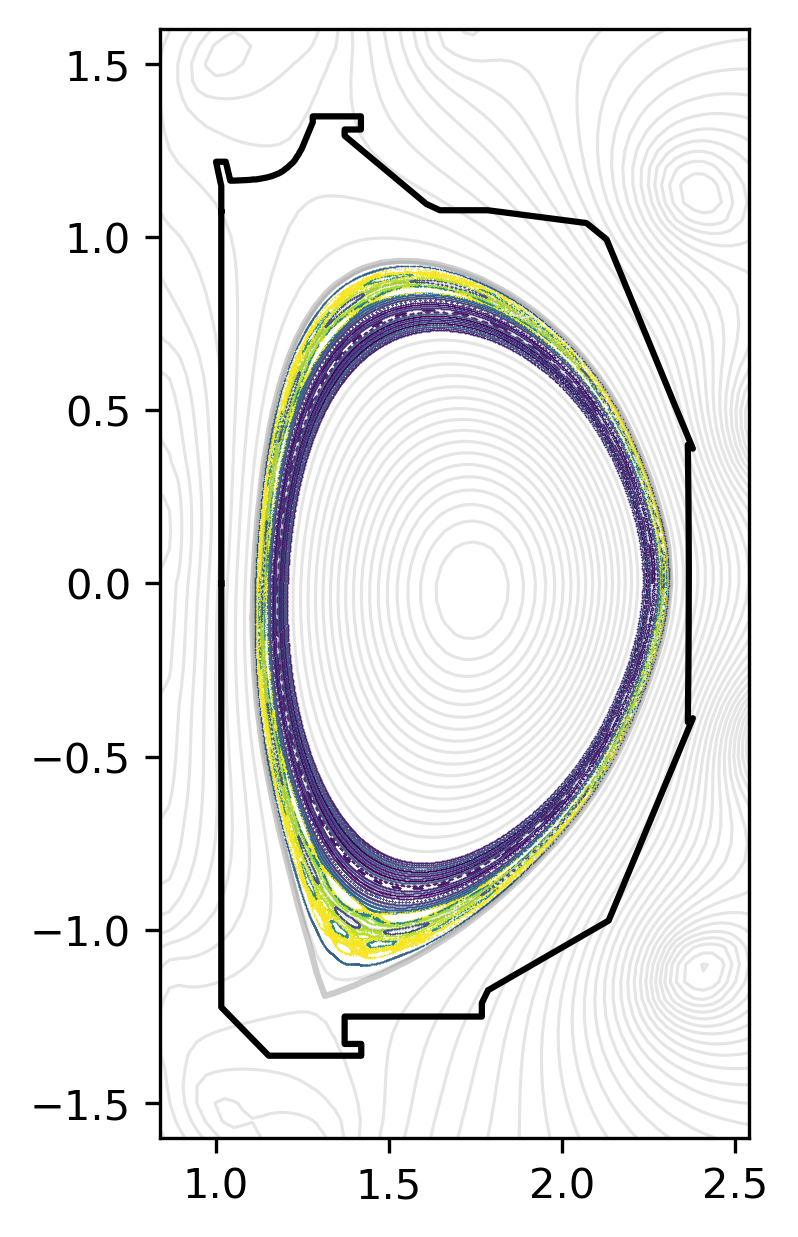

In [87]:
import matplotlib as mpl

plt.figure(dpi=300)

ax = plt.subplot(111)
eq.plot_magnetic_geometry(ax, alpha=0.2)
for k in range(r_sol.shape[1]):
    punc = npuncs[k]
    r_p, varphi_p, z_p, vll_p, mu_p = punc.yp
    psi_p = eq.interp_psi(r_p, z_p)

    ## Compute digits of accuracy via WBA

    # First, compute over full interval
    s = jnp.arange(0, r_p.shape[0])/r_p.shape[0]
    weight = jnp.exp(-1.0/(s*(1.0-s)))
    avg_psi = jnp.sum(psi_p * weight) / jnp.sum(weight)

    # Next, compute over half interval
    s_half = jnp.arange(0, r_p.shape[0]//2)/(r_p.shape[0]//2)
    weight_half = jnp.exp(-1.0/(s_half*(1.0-s_half)))
    avg_psi_half = jnp.sum(psi_p[:r_p.shape[0]//2] * weight_half) / jnp.sum(weight_half)
    digits = -jnp.log10(0.5*jnp.abs((avg_psi - avg_psi_half)/(avg_psi + avg_psi_half)))
    #print(digits)

    plt.scatter(r_p, z_p, s=(72/100.0)**2, lw=0.0, marker='.', color=mpl.cm.viridis(1.0-(digits-3.0)/(9.0-3.0)))

In [28]:
len(sol.ts)

4097

## Old Code
Code below here is old!

In [ ]:
# Test: compute the vector potential
rmesh, zmesh = jnp.meshgrid(eq.rgrid, eq.zgrid)
bv = eq.compute_bv(rmesh.ravel(), zmesh.ravel()).reshape((3,) + rmesh.shape)
ar = jnp.cumsum(bv[1,...], axis=0) * (eq.zgrid[1]-eq.zgrid[0])
ar = ar - (ar[eq.Nz//2, :])[None, :]

interp_ar = interpax.Interpolator2D(eq.rgrid, eq.zgrid, ar.T, method='cubic2')

In [31]:
# %% Pusher for drift-kinetic particles
pp = particle_motion.deut



term = diffrax.ODETerm(particle_motion.f_driftkinetic_midplane)
solver = diffrax.Dopri5()
saveat = diffrax.SaveAt(t0=True, t1=True, steps=True)
args = particle_motion.PusherArgs(eq=eq, pp=pp, zonal_fields=interp_phi, vector_potential_r=interp_ar)
stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)

# Termination condition for passing particles
def cond_copassing(t, y, args, **kwargs):
    r, varphi, z, vll, mu, theta_pol, theta_vll, action = y
    # Pick only the first particle if multiple particles are being pushed
    return jnp.ravel(theta_pol)[0] - 2 * jnp.pi

def cond_ctrpassing(t, y, args, **kwargs):
    r, varphi, z, vll, mu, theta_pol, theta_vll, action = y
    return jnp.ravel(theta_pol)[0] + 2 * jnp.pi

def cond_bounce(t, y, args, **kwargs):
    r, varphi, z, vll, mu, theta_pol, theta_vll, action = y
    return jnp.ravel(theta_vll)[0] - 2 * jnp.pi

root_finder = optx.Newton(rtol=1e-5, atol=1e-5)
event = diffrax.Event((cond_copassing, cond_ctrpassing, cond_bounce), root_finder)

@jax.vmap
def orbit_freqs(y0):
    sol = diffrax.diffeqsolve(term, solver, t0=0, t1=1.0, dt0=5e-4, y0=y0,
                            max_steps=512,
                            args=args,
                            stepsize_controller=stepsize_controller,
                            event=event,
                            throw=False)
    
    r, varphi, z, vll, mu, theta_pol, theta_vll, action = sol.ys

    omega_tor = varphi[-1] / sol.ts[-1]
    winding_pol = theta_pol[-1] / (2 * jnp.pi)
    winding_vll = theta_vll[-1] / (2 * jnp.pi)
    # Note: this is the unsigned frequency; need to multiply by the appropriate winding number to get the signed frequency
    omega_pol = 2*jnp.pi / sol.ts[-1]

    lphi, ham = particle_motion.compute_driftkinetic_integrals(0.0, y0[:5], args)

    return omega_tor, omega_pol, winding_pol, winding_vll, action[-1], lphi, ham, sol




In [32]:
# %% Push multiple particles and check timesteps
%matplotlib inline
n_part = 1024*16

r0 = jnp.array(np.random.rand(n_part)*0.15 + 2.1)
z0 = jnp.array(np.random.rand(n_part)*0.15 - 0.075 + eq.zaxis)
varphi0 = jnp.zeros_like(r0)
#vll0 = jnp.array(np.random.randn(n_part)*pp.vt)
vll0 = jnp.array(4*(np.random.rand(n_part)-0.5)*pp.vt)
mu0 = jnp.ones_like(r0) * pp.m * (pp.vt **2) / (2 * 1.0)
theta_pol0 = jnp.zeros_like(r0)
theta_vll0 = jnp.zeros_like(r0)
action0 = jnp.zeros_like(r0)

y0 = (r0, z0, varphi0, vll0, mu0, theta_pol0, theta_vll0, action0)

# %% Compute frequencies
inputs = y0
freqs = orbit_freqs(inputs)


#
#sol = diffrax.diffeqsolve(term, solver, t0=0, t1=1.0, dt0=5e-4, y0=y0,
#                            args=args,
#                            saveat=saveat,
#                            stepsize_controller=stepsize_controller,
#                            throw=False)
#
#plt.figure()
#plt.plot(np.diff(sol.ts))

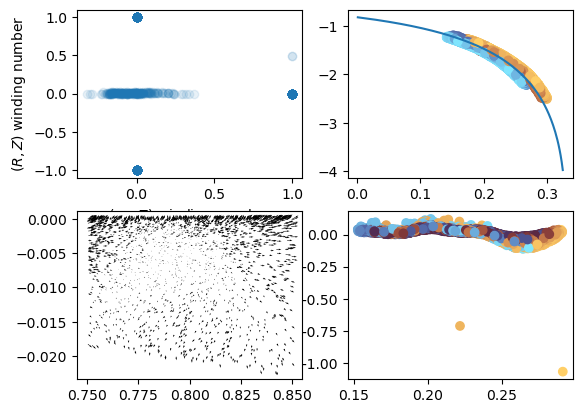

In [33]:
# %% Plot of winding numbers and q profiles
%matplotlib inline
omega_tor, omega_pol, winding_pol, winding_vll, action, lphi, ham, sols = freqs

plt.figure()
# Plot winding numbers
plt.subplot(221)
plt.scatter(winding_vll, winding_pol, alpha=0.1)
plt.xlabel(R'$(v_\parallel, Z)$ winding number')
plt.ylabel(R'$(R,Z)$ winding number')

# Plot passing particles
plt.subplot(222)
pfilter = np.logical_or((np.round(winding_pol) == -1), (np.round(winding_pol) == +1))
plt.scatter(lphi[pfilter], omega_tor[pfilter] / omega_pol[pfilter] * np.round(winding_pol)[pfilter], c=vll0[pfilter], cmap='managua')
plt.plot(geom.psi_surf, geom.q_surf)

# Plot trapped particles
plt.subplot(224)
pfilter = (np.round(winding_vll) != 0)
plt.scatter(lphi[pfilter], omega_tor[pfilter] / omega_pol[pfilter], c=vll0[pfilter], cmap='managua')

# Plot frequencies for trapped particles
plt.subplot(223)
pfilter = np.logical_and(np.logical_and(np.logical_and((np.round(winding_pol) == 0), (np.round(winding_vll) == +1)), np.abs(lphi/eq.psix - 0.8) < 0.05), action < 0.02)

plot_tor = omega_tor[pfilter] + 0.05*30
plot_pol = omega_pol[pfilter] - np.median(omega_pol[pfilter])

plt.quiver(lphi[pfilter]/eq.psix, action[pfilter], plot_tor / jnp.std(plot_tor), plot_pol / jnp.std(plot_pol))

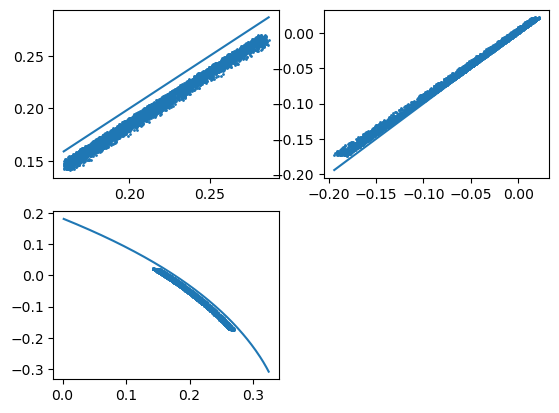

In [34]:
# %% Compare the computed actions

pfilter = np.logical_and((np.round(winding_pol) == 1), (np.round(winding_vll) == 0))

psi = eq.interp_psi(r0[pfilter], z0[pfilter])

torflux = geom.interp_torflux(psi)

plt.figure()
plt.subplot(221)
plt.scatter(psi, lphi[pfilter], s=1)
data_range = jnp.array([np.min(psi), np.max(psi)])
plt.plot(data_range, data_range)

plt.subplot(222)
plt.scatter(torflux - torflux[0], action[pfilter] - action[pfilter][0], s=1)
data_range = jnp.array([np.min(torflux - torflux[0]), np.max(torflux - torflux[0])])
plt.plot(data_range, data_range)

plt.subplot(223)
plt.plot(geom.psi_surf, geom.interp_torflux(geom.psi_surf) - torflux[0])
plt.scatter(lphi[pfilter], action[pfilter] - action[pfilter][0], s=1)

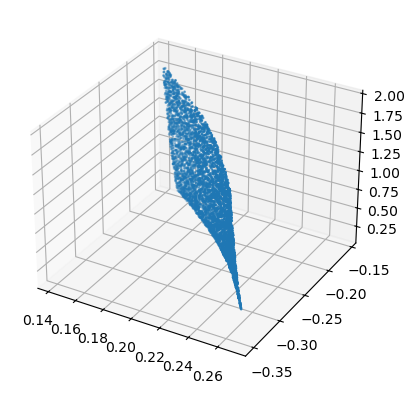

In [35]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

pfilter = np.logical_and((np.round(winding_pol) == 1), (np.round(winding_vll) == 0))
ax.scatter(lphi[pfilter], action[pfilter], ham[pfilter], s=1)

np.savez('./tests/orbit_data.npz',
         lphi=lphi,
         action=action,
         ham=ham,
         winding_pol=winding_pol,
         winding_vll=winding_vll,
         omega_tor=omega_tor,
         omega_pol=omega_pol)

(array([ 29., 102., 125., 134., 122., 135., 126., 112., 131., 122., 105.,
        109., 148., 133., 110., 111., 117., 130., 113., 122., 121., 108.,
         97.,  96., 125., 103., 118.,  96., 100.,  92.,  94.,  88.,  96.,
         93.,  60.,  92.,  91.,  72.,  58.,  51.,  44.,  49.,  43.,  29.,
         22.,  20.,  13.,  10.,   4.,   5.]),
 array([-253.41942022, -249.14355056, -244.86768089, -240.59181123,
        -236.31594157, -232.0400719 , -227.76420224, -223.48833258,
        -219.21246291, -214.93659325, -210.66072358, -206.38485392,
        -202.10898426, -197.83311459, -193.55724493, -189.28137527,
        -185.0055056 , -180.72963594, -176.45376628, -172.17789661,
        -167.90202695, -163.62615729, -159.35028762, -155.07441796,
        -150.7985483 , -146.52267863, -142.24680897, -137.97093931,
        -133.69506964, -129.41919998, -125.14333032, -120.86746065,
        -116.59159099, -112.31572133, -108.03985166, -103.763982  ,
         -99.48811234,  -95.21224267,  -90.936

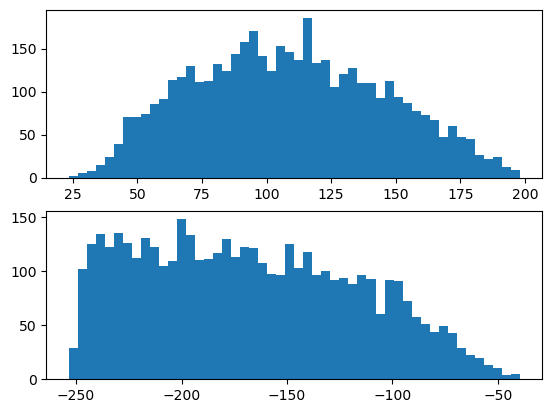

In [31]:
%matplotlib inline
plt.figure()
plt.subplot(211)
plt.hist(omega_pol[pfilter], bins=50)
plt.subplot(212)
plt.hist(omega_tor[pfilter], bins=50)

In [ ]:
%matplotlib qt
# %% Plot trajectory of individual particle(s)
plt.figure()

r, varphi, z, vll, mu, theta_pol, theta_vll, actions = sol.ys

ax = plt.subplot(121)
ax2 = plt.subplot(122)
pfilter = np.logical_and(np.logical_and(np.round(winding_pol) == 0, np.round(winding_vll) == 1), action < 0.0005)
pinds = np.nonzero(pfilter)[0]

action_max = np.max(action[pinds])
action_min = np.min(action[pinds])

for pind in pinds:
    action_norm = np.clip((action[pind] - action_min) / (action_max - action_min), 0, 1)
    ax.plot(r[:,pind], z[:,pind], c=plt.cm.viridis(action_norm))
    ax2.plot(vll[:,pind]/pp.vt, z[:,pind], c=plt.cm.viridis(action_norm))

eq.plot_magnetic_geometry(ax)
